In [88]:
# Third party
import importlib
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# User
import encode
import pre_process
import layer
import train
import loss
import generate

importlib.reload(encode)
importlib.reload(pre_process)
importlib.reload(layer)
importlib.reload(train)
importlib.reload(loss)
importlib.reload(generate)

from encode import get_encoder_decoder
from pre_process import build_dataset
from layer import LinearLayer
from train import sgd
from loss import loss
from generate import generate



In [46]:
encoder, decoder = get_encoder_decoder(training_data="../data/shakespear.txt", type='character')
# let's now encode the entire text dataset and store it into a torch.Tensor
with open("../data/shakespear.txt", 'r', encoding='utf-8') as f:
    text = f.read()
text_encoded = torch.tensor(encoder(text), dtype=torch.long)
unique_chars = sorted(list(set(text)))
set(text), text[0:10], text_encoded[0:10]

({'\n',
  ' ',
  '!',
  '$',
  '&',
  "'",
  ',',
  '-',
  '.',
  '3',
  ':',
  ';',
  '?',
  'A',
  'B',
  'C',
  'D',
  'E',
  'F',
  'G',
  'H',
  'I',
  'J',
  'K',
  'L',
  'M',
  'N',
  'O',
  'P',
  'Q',
  'R',
  'S',
  'T',
  'U',
  'V',
  'W',
  'X',
  'Y',
  'Z',
  'a',
  'b',
  'c',
  'd',
  'e',
  'f',
  'g',
  'h',
  'i',
  'j',
  'k',
  'l',
  'm',
  'n',
  'o',
  'p',
  'q',
  'r',
  's',
  't',
  'u',
  'v',
  'w',
  'x',
  'y',
  'z'},
 'First Citi',
 tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47]))

In [32]:
token_length = 3
dataset =  build_dataset(text_encoded, 3)
train_data, train_targets = dataset["train"]
validation_data, validation_targets = dataset["validation"]
len(train_data), len(validation_data)


(948085, 167309)

In [95]:
embedding_dim = 2
Embedding = torch.randn((len(unique_chars),embedding_dim),requires_grad=True, dtype=torch.float64)

hp = {
    "init_learning_rate": .1,
    "converging_learning_rate": .01,
    "learning_rate": .1,
    "epochs": 200000,
    "dim_of_embedding": embedding_dim,
    "num_layer_1_nodes": 10,
    "mini_batch_size": 3,
    "token_length": token_length
}

l1 = LinearLayer(
    num_of_inputs=hp['token_length'] * hp['dim_of_embedding'],
    num_of_neurons=hp['num_layer_1_nodes'],
    init_scale_factor_weights=.01,
    init_scale_factor_biases=0,
    activation_func=torch.tanh,
)
l2 = LinearLayer(
    num_of_inputs=hp['num_layer_1_nodes'],
    num_of_neurons=len(unique_chars),
    init_scale_factor_weights=.01,
    init_scale_factor_biases=0
)
layers = [l1, l2]
for l in layers:
    l.require_grad()

loss_list = []
train.sgd(hp, Embedding, layers, train_data, train_targets, loss_list)


epoch: 0, loss: 4.1744
epoch: 10000, loss: 3.7374
epoch: 20000, loss: 2.1862
epoch: 30000, loss: 2.1044
epoch: 40000, loss: 1.9486
epoch: 50000, loss: 4.4186
epoch: 60000, loss: 1.4428
epoch: 70000, loss: 1.7747
epoch: 80000, loss: 1.8606
epoch: 90000, loss: 0.7716
epoch: 100000, loss: 2.5486
epoch: 110000, loss: 2.7587
epoch: 120000, loss: 3.0651
epoch: 130000, loss: 3.1133
epoch: 140000, loss: 2.9951
epoch: 150000, loss: 1.6004
epoch: 160000, loss: 2.8985
epoch: 170000, loss: 3.1603
epoch: 180000, loss: 2.1784
epoch: 190000, loss: 3.8683


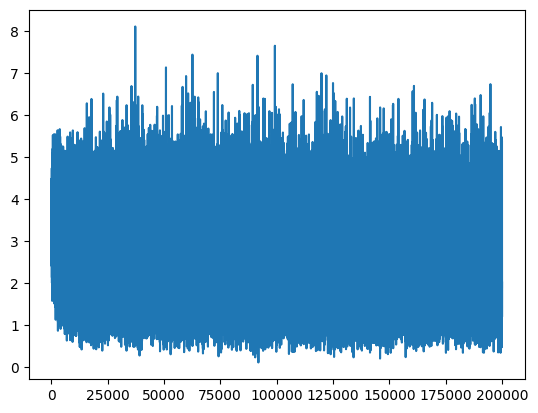

In [96]:
plt.plot(loss_list)

In [97]:
# Compute negative log likelihood of the train/validation

train_loss = loss(train_data, train_targets, Embedding, layers, hp)
validation_loss = loss(validation_data, validation_targets, Embedding, layers, hp)
print(f"train loss: {train_loss}")
print(f"validation loss: {validation_loss}")



train loss: 2.4249824190616915
validation loss: 2.422851474047508


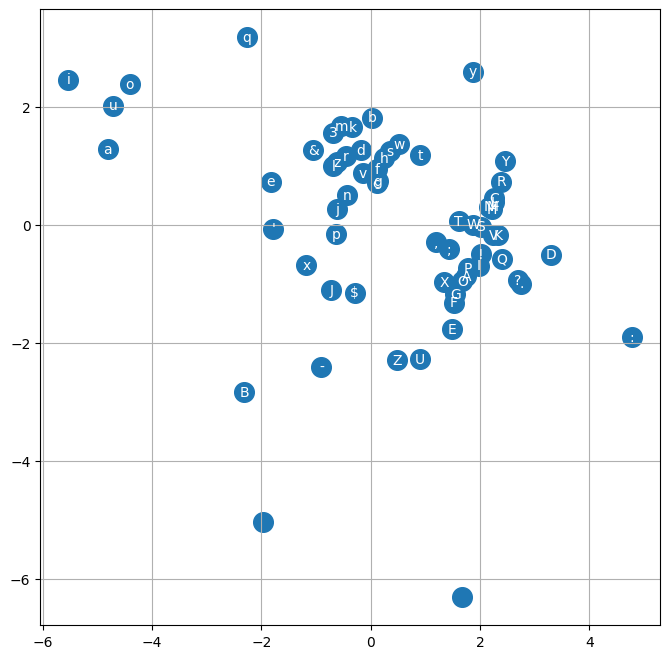

In [98]:



# visualize dimensions 0 and 1 of the embedding matrix C for all characters
itos = {i: ch for i, ch in enumerate(unique_chars)}
plt.figure(figsize=(8,8))
plt.scatter(Embedding[:,0].data, Embedding[:,1].data, s=200)
for i in range(Embedding.shape[0]):
    plt.text(Embedding[i,0].item(), Embedding[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')




In [99]:
decoder(generate(Embedding, layers, hp, 200))

"I:OT:\nMhaf,' have, ange hy go,d cacbs lur,\nTot and theskiw kegencs be caw:\nEos the jirs atc se dath to yom seagoert, min emasw the it coses, pres tor coy hore.\n\nRL Shic kess mlel bon.\n\nWA\nReoll edatI\n"